In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

N = [30, 100, 300]
D = 0.02        # en cm
rho_0 = 1e-5    # en C/m^3
Va = 0          # ambos V en Volts
Vb = 10
e_0 = 8.85e-12  # permisividad del vacío

def gauss_elimination(N, method = "standard"):
  h = D / (N + 1)

  x = np.linspace(h, D-h, N)
  rho = rho_0 * np.sin(np.pi * x / D)
  f = -rho / e_0
  fh2 = f * h**2
  fh2[0] -= Va
  fh2[-1] -= Vb

  # Construimos la matriz tridiagonal A
  A = np.zeros((N, N))
  for i in range(N):
      for j in range(N):
          if i == j:
              A[i, j] = -2.
          elif abs(i - j) == 1:
              A[i, j] = 1.

  # Initializamos el vector solucion v
  v = np.zeros(N)

  # eliminacion de Gauss
  if method == "standard":
    start = time.perf_counter()
    for i in range(N):  # i is the column index
        p1 = A[i, i]
        for j in range(N):  # j is the pivot row index
            if j > i:
                p2 = A[j, i]
                fh2[j] -= p2 * fh2[i] / p1
  #              A[j,:] -= p2 * A[i,:] / p1
                for k in range(N):
                    A[j, k] = A[j, k] - p2 * A[i, k] / p1
    end = time.perf_counter()
    delta_t = end - start

  if method == "modified" :
    start = time.perf_counter()
    a = np.ones(N-1)  # Diagonal inferior
    b = -2 * np.ones(N)  # Diagonal principal
    c = np.ones(N-1)  # Diagonal superior

    # Eliminación hacia adelante
    for i in range(1, N):
        factor = a[i-1] / b[i-1]
        b[i] -= factor * c[i-1]
        f[i] -= factor * f[i-1]

    # Sustitución regresiva
    v = np.zeros(N)
    v[-1] = f[-1] / b[-1]
    for i in range(N-2, -1, -1):
        v[i] = (f[i] - c[i] * v[i+1]) / b[i]
    end = time.perf_counter()
    delta_t = end - start

  # sustitucion
  for i in range(N - 1, -1, -1):
      suma = np.dot(A[i, i + 1:], v[i + 1:])
      v[i] = (fh2[i] - suma) / A[i, i]

  # Incluir los datos en los limites
  x_full = np.concatenate(([0], x, [D]))
  v_full = np.concatenate(([Va], v, [Vb]))

  rho_full = rho_0 * np.sin(np.pi * x_full / D) # Calculate rho for x_full
  f_full = -rho_full / e_0

  return [x_full, f_full, v_full, delta_t]



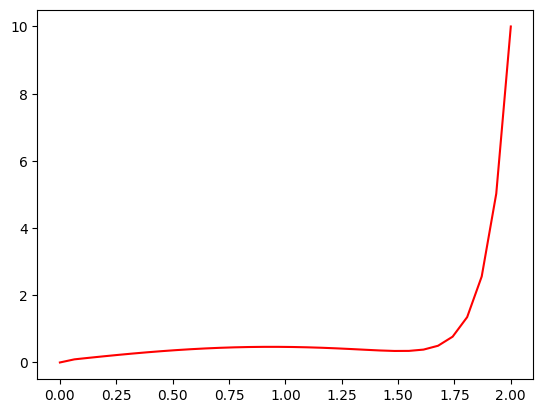

In [2]:
mod = gauss_elimination(30, 'modified')

plt.plot(mod[0]*100, mod[2], color='red', label='Analítico')
plt.show()

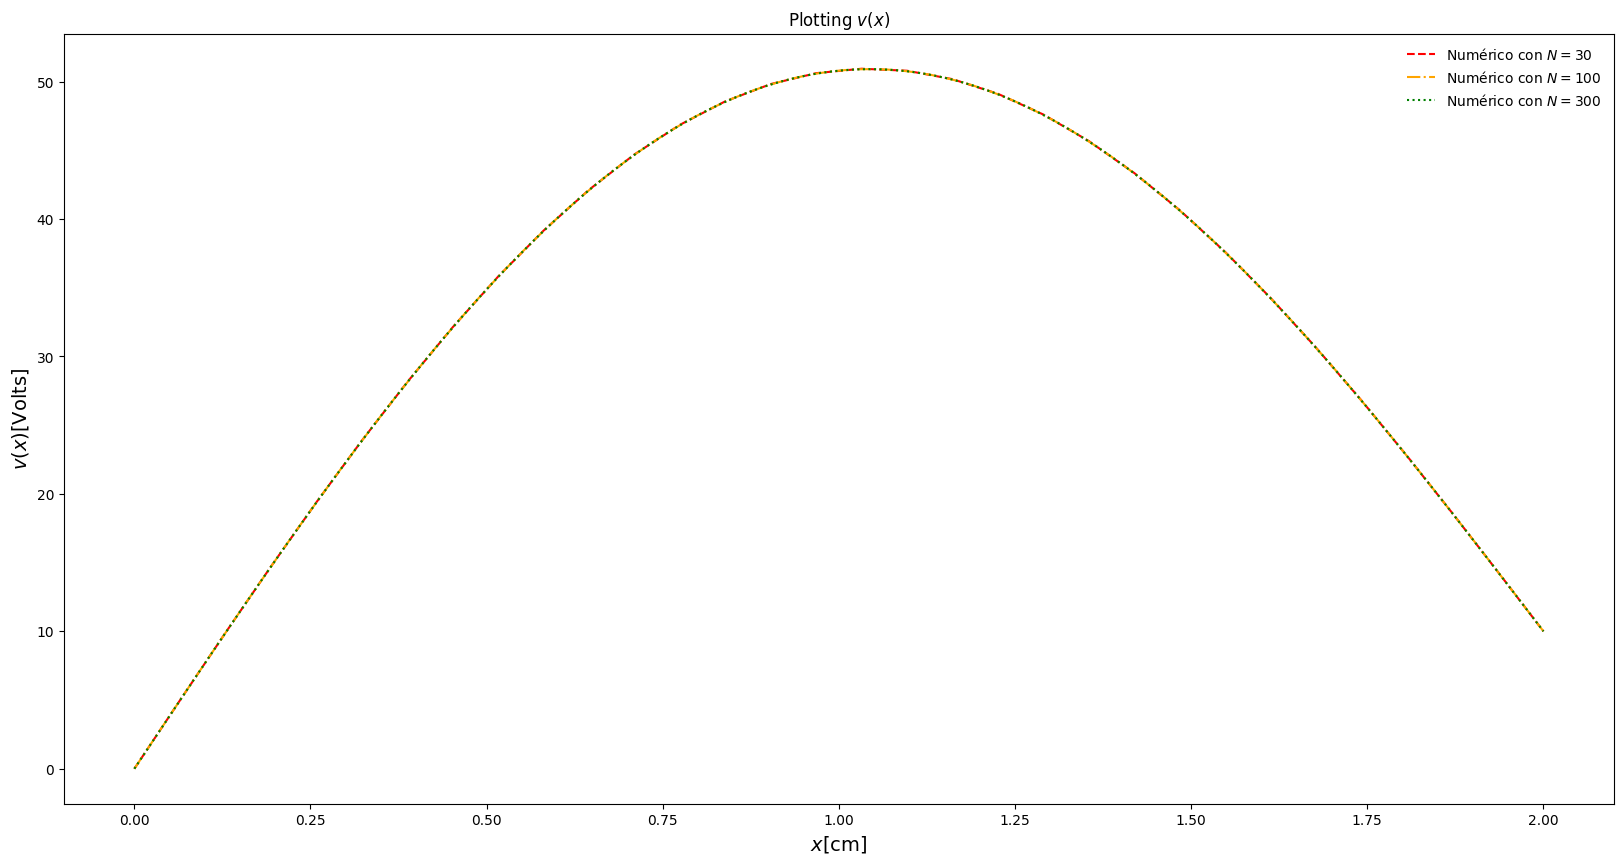

In [6]:
plt.figure(figsize = (20,10))
plt.title('Plotting ${v}({x})$')
plt.xlabel("${x} $[cm]", fontsize=14)
plt.ylabel("${v}({x}) $[Volts]", fontsize=14)

N_styles = [(30, 'red', '--'), (100, 'orange', '-.'), (300, 'green', ':')]
for (n, c, l) in N_styles:
    # Graficamos las soluciones v(x) para distintos N
    plt.plot(gauss_elimination(n, 'standard')[0]*100, gauss_elimination(n, 'standard')[2], color = c, ls = l, label = 'Numérico con $N = ' + str(n) + '$')
    #if i[0] == 300:
         #plt.plot(gauss_elimination(i[0], 'standard')[0]*100, vt, color='blue', label='Analítico')

plt.legend(loc='upper right', frameon=False)
plt.show()

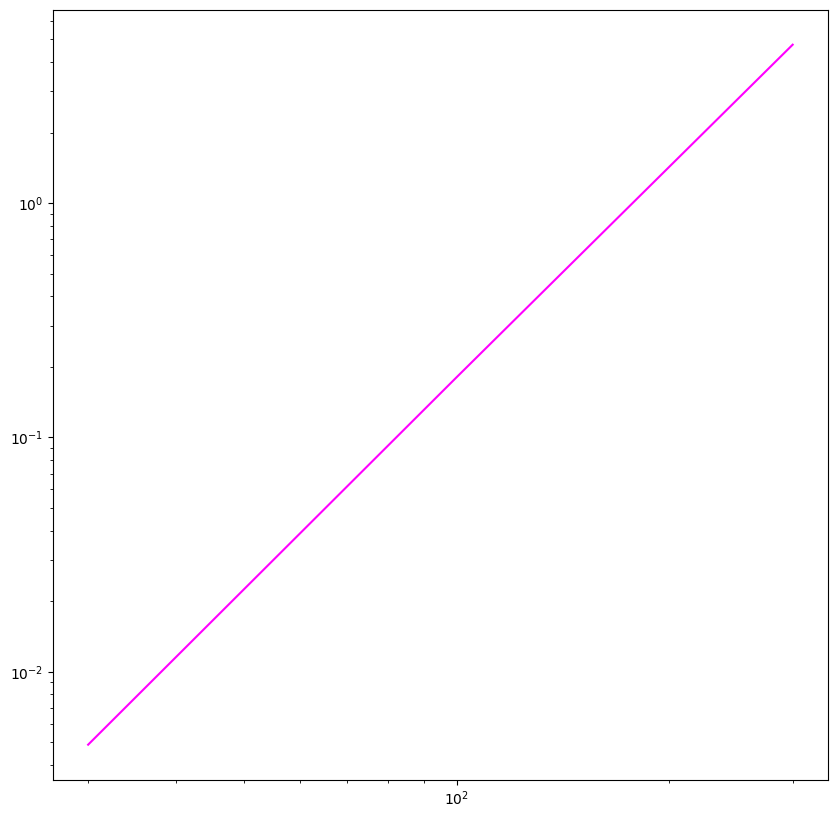

In [ ]:
str_N = [str(x) for x in N]
delta_ts = pd.DataFrame(index = ['Standard', 'Modified'],columns = str_N)
for i in N:
    delta_ts[str(i)] = [gauss_elimination(i, 'standard')[3], gauss_elimination(i, 'modified')[3]]

d_t_N = delta_ts.loc['Standard'].tolist()
plt.figure(figsize = (10, 10))
plt.plot(N, d_t_N, color = 'magenta')
plt.yscale('log')
plt.xscale('log')
plt.show()